In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [15]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from data_gen import *
from model_v2 import *

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Gen

In [48]:
X_train, y_train = get_train_data([5000,5000])

train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i].float(), y_train[i].float()])

In [49]:
# This allows you to look into trainloader, and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(i1.dtype)
print(l1.dtype)

torch.float32
torch.float32


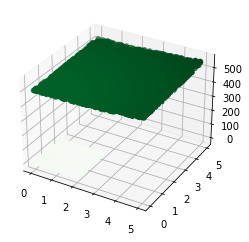

In [50]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:,1], y_train, c=y_train, cmap='Greens');

## Model

In [51]:
emb_dims = [2,10]

# Always keep batch size in powers of 2, trainloader is faster this way.
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [52]:
# Use dropout of at least 0.1, maximum of 0.5
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[10], output_size=1, hidden_drop_p=0, batch_flag=False)

n_epochs = 100
loss_values = []
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

t = tqdm(range(n_epochs), miniters=100)
for epoch in t:
    total_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2].long()

        preds = model(cont_x, cat_x)

        loss = criterion(preds, nn.BatchNorm1d(1, affine=False)(labels.view(-1,1)))
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t.set_description(f"----- Epoch: {epoch}/{n_epochs} Loss: {total_loss/num_batches} -----")
    loss_values.append(total_loss/num_batches)

----- Epoch: 99/100 Loss: 0.00896453704092581 -----: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


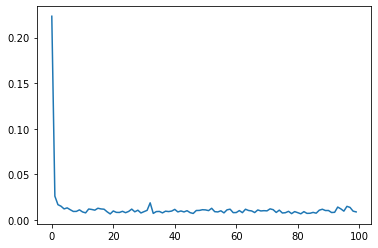

In [53]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
